In [1]:
# Basic Libraries
from bs4 import BeautifulSoup
import requests
import pandas as pd
import time 
import random
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
sb.set() # set the default Seaborn style for graphics

AMD_data = pd.read_csv('AMD_cleaned.csv')
AMD_data = AMD_data.drop(columns = ['Unnamed: 0'])
Nvidia_data = pd.read_csv('Nvidia_cleaned.csv')
Nvidia_data = Nvidia_data.drop(columns = ['Unnamed: 0'])

In [2]:
frames = [AMD_data, Nvidia_data]
combined_data = pd.concat(frames)
combined_data = combined_data.dropna(subset=['Max. TDP (W)'])
combined_data = combined_data.drop(columns = ['Arbitrary Gen', 'Shading Units'])
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 496 entries, 0 to 278
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Manufacturer             496 non-null    object 
 1   Foundry                  496 non-null    object 
 2   Architecture             496 non-null    object 
 3   Gen Year                 496 non-null    int64  
 4   FP32 (float) in GFLOPS   496 non-null    float64
 5   Memory Size (MB)         496 non-null    float64
 6   Memory Type              496 non-null    object 
 7   Bus Width (bits)         496 non-null    int64  
 8   GPU clock (MHz)          496 non-null    float64
 9   Memory clock (MHz)       496 non-null    float64
 10  Process Size (nm)        496 non-null    float64
 11  Transistors (millions)   496 non-null    float64
 12  Density (M/mm²)          496 non-null    float64
 13  Die Size (mm²)           496 non-null    float64
 14  Max. TDP (W)             496 no

In [3]:
# Identifying categorical variables for encoding
categorical_cols = combined_data.select_dtypes(include=['object']).columns

# Displaying unique values in each categorical column to assess need for encoding
{col: combined_data[col].nunique() for col in categorical_cols}

{'Manufacturer': 2, 'Foundry': 4, 'Architecture': 24, 'Memory Type': 10}

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Selecting features and target variables
X = combined_data[['Manufacturer', 'Foundry', 'Architecture', 'Memory Type', 'Memory Size (MB)', 'Bus Width (bits)', 
          'GPU clock (MHz)', 'Memory clock (MHz)', 'Process Size (nm)', 'Transistors (millions)', 
          'Density (M/mm²)', 'Die Size (mm²)', 'Max. TDP (W)', 'L2 Cache (KB)']]
y = combined_data[['FP32 (float) in GFLOPS', 'Pixel Rate (GPixel/s)', 'Texture Rate (GTexel/s)']]

# Defining numerical and categorical columns
numerical_cols = ['Memory Size (MB)', 'Bus Width (bits)', 'GPU clock (MHz)', 'Memory clock (MHz)', 
                  'Process Size (nm)', 'Transistors (millions)', 'Density (M/mm²)', 'Die Size (mm²)', 
                  'Max. TDP (W)', 'L2 Cache (KB)']
categorical_cols = ['Manufacturer', 'Foundry', 'Architecture', 'Memory Type']

# Creating a transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Showing the shapes of the training and testing sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((396, 14), (100, 14), (396, 3), (100, 3))

In [5]:
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor

# Creating the XGBoost model
xgb_model = XGBRegressor(n_estimators=50, max_depth=3, objective='reg:squarederror')

# Setting up the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', MultiOutputRegressor(xgb_model))])

# Training the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Memory Size (MB)',
                                                   'Bus Width (bits)',
                                                   'GPU clock (MHz)',
                                                   'Memory clock (MHz)',
                                                   'Process Size (nm)',
                                                   'Transistors (millions)',
                                                   'Density (M/mm²)',
                                                   'Die Size (mm²)',
                                                   'Max. TDP (W)',
                                                   'L2 Cache (KB)']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Manufacturer', 'Foundry',
                                                   'Architecture',
                                                   'M...
                                                             gpu_id=None,
                                                             grow_policy=None,
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=None,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=3,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             n_estimators=50,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             predictor=None,
                                                             random_state=None, ...)))])

In [6]:
from sklearn.metrics import mean_squared_error, r2_score
# Predicting on training and testing data
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# Calculating RMSE and R² for training and testing sets
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

(train_rmse, train_r2, test_rmse, test_r2)

(286.84671801023546,
 0.9977837001726447,
 1709.1802832488045,
 0.9574181920825623)

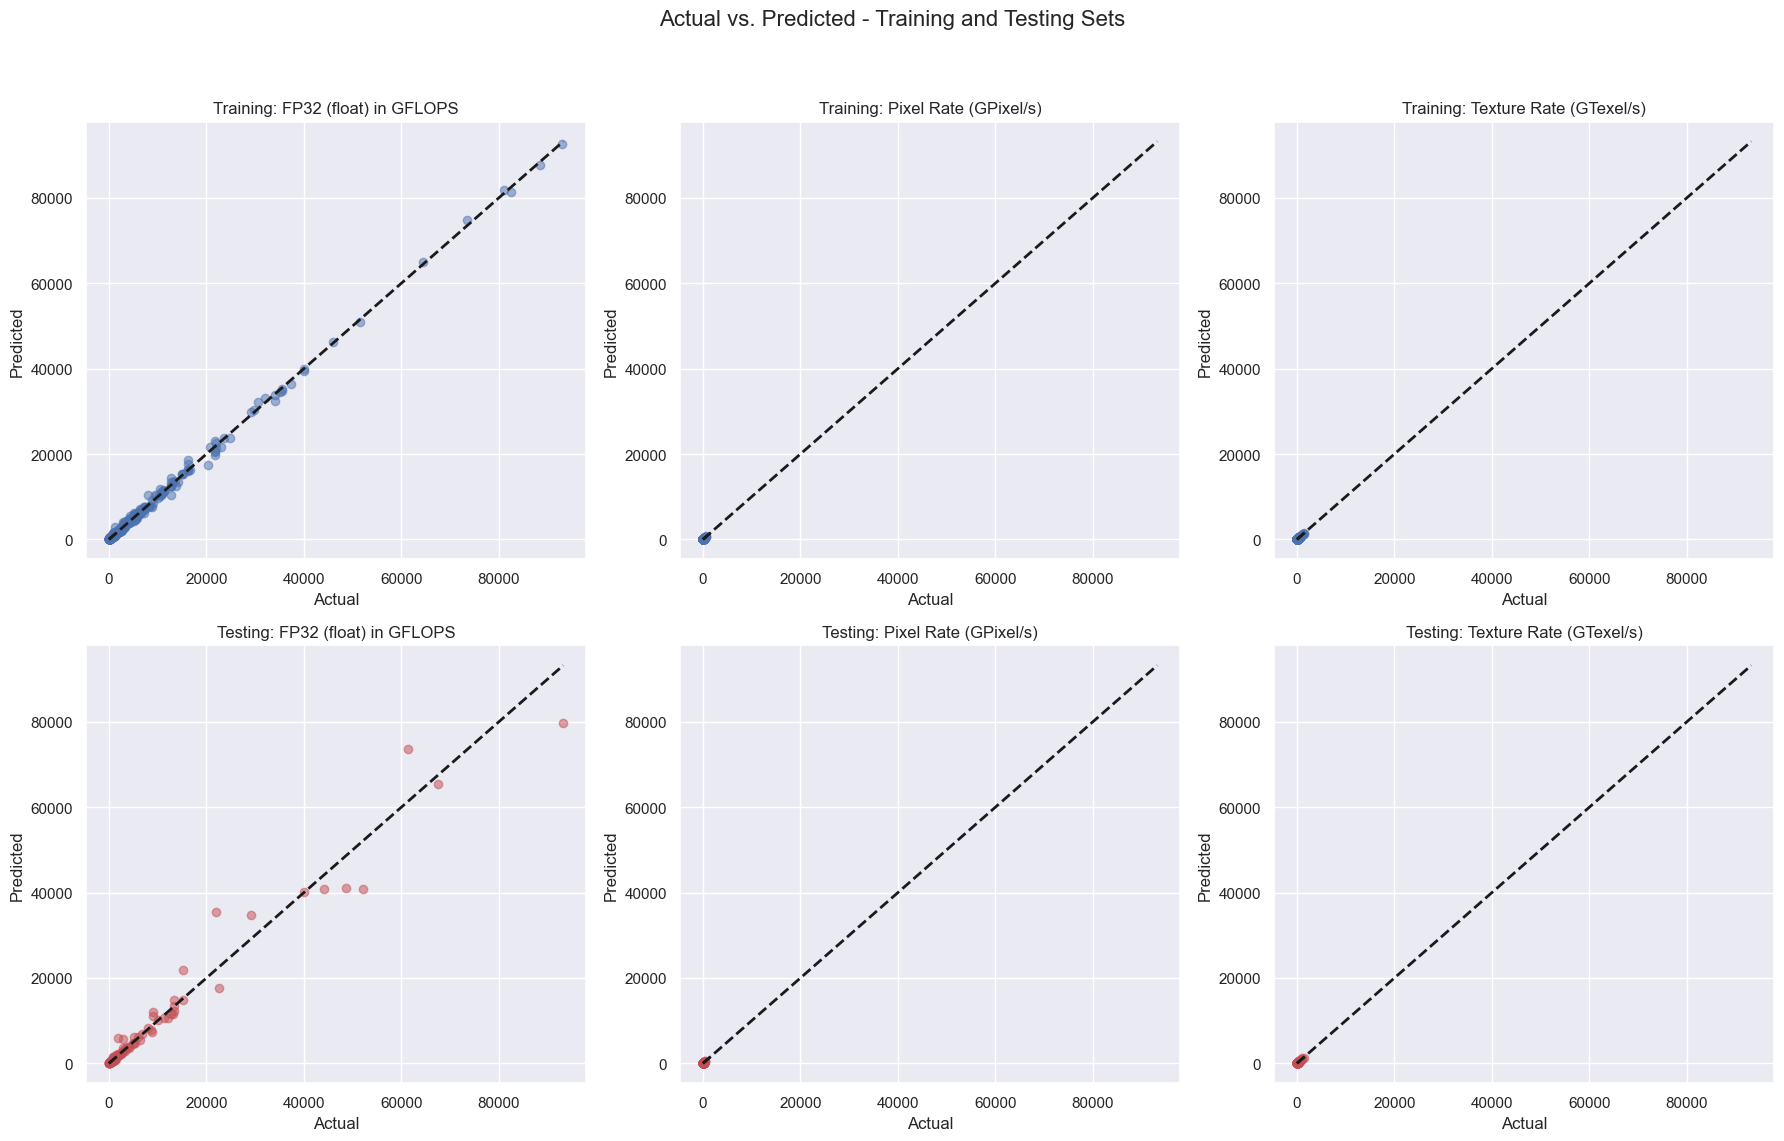

In [7]:
import matplotlib.pyplot as plt
# Setting up the plots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
fig.suptitle('Actual vs. Predicted - Training and Testing Sets', fontsize=16)

# Titles for subplots
titles = ['FP32 (float) in GFLOPS', 'Pixel Rate (GPixel/s)', 'Texture Rate (GTexel/s)']

# Plotting training data
for i in range(3):
    axes[0, i].scatter(y_train.iloc[:, i], y_train_pred[:, i], alpha=0.5)
    axes[0, i].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    axes[0, i].set_title(f'Training: {titles[i]}')
    axes[0, i].set_xlabel('Actual')
    axes[0, i].set_ylabel('Predicted')

# Plotting testing data
for i in range(3):
    axes[1, i].scatter(y_test.iloc[:, i], y_test_pred[:, i], alpha=0.5, color='r')
    axes[1, i].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    axes[1, i].set_title(f'Testing: {titles[i]}')
    axes[1, i].set_xlabel('Actual')
    axes[1, i].set_ylabel('Predicted')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [8]:
# Extract feature importances from each regressor and average them
importances = np.array([est.feature_importances_ for est in pipeline.named_steps['regressor'].estimators_])
mean_importances = np.mean(importances, axis=0)

# Getting feature names after preprocessing (handling categorical variables)
feature_names = (pipeline.named_steps['preprocessor'].transformers_[1][1]
                 .get_feature_names_out(categorical_cols))
all_feature_names = np.concatenate([numerical_cols, feature_names])

# Creating a DataFrame for easier visualization
importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': mean_importances
}).sort_values(by='Importance', ascending=False)

importance_df.head(10)

,Feature,Importance
5,Transistors (millions),0.743935
0,Memory Size (MB),0.143945
47,Memory Type_HBM2,0.015537
2,GPU clock (MHz),0.015347
10,Manufacturer_AMD,0.011319
3,Memory clock (MHz),0.009831
13,Foundry_Samsung,0.007603
16,Architecture_Ampere,0.006270
6,Density (M/mm²),0.006243
1,Bus Width (bits),0.005865


### Comment:

Here, we used the Pixel Rate and Texture Rate together with FP32 (float) as a measure of performance. Using Multi Output Regression, we are able to have multiple response variables. We also make use of XGBoost as seen from the previous Notebook as it was shown to be the most balance.

Unsurprisingly, Transistors is the most important features, consistent with the previous 3 models.

### Why Multi Output Regressor?

FP32 is the commonly used variable as a benchmark for measuring performance so single output model is sufficient but we were curious in what would happen if we take into account Pixel Rate and Texture Rate of the GPUs as a part of the measure of performance.

### Now we want to try to find which foundry makes the best chips 

Based on these variables FP32, Max TDP, Texture Rate and Pixel Rate as these are variables related to performance most

/Users/bernard/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/bernard/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/bernard/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/bernard/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will chang

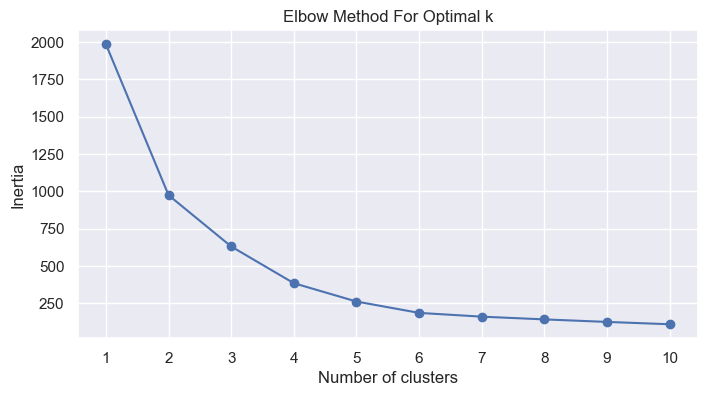

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Normalize the data
scaler = StandardScaler()
features = combined_data[['FP32 (float) in GFLOPS', 'Max. TDP (W)','Pixel Rate (GPixel/s)', 'Texture Rate (GTexel/s)']]
scaled_features = scaler.fit_transform(features)

# Use the Elbow method to determine the optimal number of clusters
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow curve
plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [10]:
# Apply k-means clustering with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
combined_data['Cluster'] = kmeans.fit_predict(scaled_features)


numeric_columns = ['FP32 (float) in GFLOPS', 'Max. TDP (W)', 'Pixel Rate (GPixel/s)', 'Texture Rate (GTexel/s)', 'Cluster']
numeric_data = combined_data[numeric_columns]

# Calculate the mean performance metrics for each cluster
cluster_means = numeric_data.groupby('Cluster').mean()

foundry_distribution = combined_data.groupby(['Cluster', 'Foundry']).size().unstack(fill_value=0)

# Display the corrected cluster means and the previously shown foundry distribution
cluster_means, foundry_distribution

/Users/bernard/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(         FP32 (float) in GFLOPS  Max. TDP (W)  Pixel Rate (GPixel/s)  \
 Cluster                                                                
 0                   1237.552102    101.789831              15.800129   
 1                  50144.642857    444.071429             340.067857   
 2                   7653.687861    364.815029              75.016532   
 
          Texture Rate (GTexel/s)  
 Cluster                           
 0                      40.312597  
 1                     835.057143  
 2                     198.824220  ,
 Foundry  GlobalFoundries  Samsung  TSMC  UMC
 Cluster                                     
 0                     22        9   263    1
 1                      0        4    24    0
 2                     12       18   143    0)

### Cluster Analysis

#### Cluster 0 (Low Performance):

FP32 (float) in GFLOPS: 1,237.55 (low computational power)

Max. TDP (W): 101.79 (lower power consumption)

Pixel Rate (GPixel/s): 15.80 (lower pixel processing rate)

Texture Rate (GTexel/s): 40.31 (lower texture processing rate)

Foundry Distribution: Dominated by TSMC with 263 units, followed by GlobalFoundries (22), Samsung (9), and UMC (1). This cluster represents chips that are likely designed for lower-end or energy-efficient applications where high performance is not the primary concern.

#### Cluster 1 (High Performance):

FP32 (float) in GFLOPS: 50,144.64 (very high computational power)

Max. TDP (W): 444.07 (high power consumption)

Pixel Rate (GPixel/s): 340.07 (high pixel processing rate)

Texture Rate (GTexel/s): 835.06 (high texture processing rate)

Foundry Distribution: Primarily produced by TSMC (24), with a smaller output from Samsung (4). This cluster features high-performance chips, likely targeted at applications requiring intensive computational tasks such as gaming, data centers, or advanced graphics processing.

#### Cluster 2 (Medium Performance):

FP32 (float) in GFLOPS: 7,653.69 (moderate computational power)

Max. TDP (W): 364.82 (moderate to high power consumption)

Pixel Rate (GPixel/s): 75.02 (moderate pixel processing rate)

Texture Rate (GTexel/s): 198.82 (moderate texture processing rate)

Foundry Distribution: Mostly TSMC (143), with contributions from Samsung (18) and GlobalFoundries (12). This cluster likely represents a mid-range product line that balances performance and power consumption, suitable for mainstream consumer applications.

#### Insights:

TSMC's Dominance: TSMC is a key player across all performance levels but especially prominent in the production of high and low-performance chips. This indicates TSMC's broad market coverage and capability to manufacture diverse products catering to various market needs. TSMC is one of the largest foundaries in the world and its ability to provide high volume and economies of scale lead to it being one of the top manufacters of the chips in the world. TSMC has a wide majortiy of not just leading  5nm , 3nm and 2nm processes but also 28nm, 16nm FINFET which provides a wide range of options for customers seeing to balance power, efficency and price. 


Market Positioning of Foundries: GlobalFoundries and Samsung also contribute across different clusters, but with fewer chips in the high-performance cluster, indicating that their market positioning might be more focused on mid to low-range products compared to TSMC. This is closely aligned with external factors such as globalfoundaries decision not to develop leading process nodes and instead focus on pre-exisiting mature nodes. 


Specialization and Target Markets: The clustering suggests that the foundries might have different target markets or areas of specialization. TSMC’s presence in the high-performance cluster suggests a strong positioning in markets that require high computational power. TSMC has been a key player in developing leading edge process nodes such as the 3NM and 2NM EUV GAA-FET processes. this is strongly reflected in the ability of TSMC to develop High performance computing nodes leading to it being the leading foundary of choice for high performance computing. 

### Why KMeans Clustering?

Simplicity and Efficiency: K-means is straightforward to implement and understand. It's efficient on large datasets, primarily when the number of clusters is small relative to the number of data points.

Scalability: K-means works well with large datasets, especially with efficient implementations such as those in the scikit-learn library.

In [11]:
# Split the dataset into 3 dataframes based on clusters
cluster_0 = combined_data[combined_data['Cluster'] == 0]
cluster_1 = combined_data[combined_data['Cluster'] == 1]
cluster_2 = combined_data[combined_data['Cluster'] == 2]

# Display basic information about each cluster to verify correct splitting
(cluster_0.shape, cluster_1.shape, cluster_2.shape)

((295, 19), (28, 19), (173, 19))

### Lets try to do XGBoost to find the feature importance on the lowest performing chips as it has the most datapoints

In [12]:
cluster_0 = cluster_0.drop(columns = ['Pixel Rate (GPixel/s)', 'Texture Rate (GTexel/s)', 'Max. TDP (W)'])

In [13]:
from sklearn.preprocessing import OneHotEncoder

# One-hot encode the categorical columns
categorical_columns = ['Manufacturer', 'Foundry', 'Architecture', 'Memory Type']
one_hot_encoder = OneHotEncoder()
encoded_categorical = one_hot_encoder.fit_transform(cluster_0[categorical_columns]).toarray()
encoded_categorical_df = pd.DataFrame(encoded_categorical, columns=one_hot_encoder.get_feature_names_out())

# Combine the encoded categorical data with the numeric data
numeric_columns = cluster_0.drop(columns=categorical_columns + ['FP32 (float) in GFLOPS'])
full_data = pd.concat([encoded_categorical_df, numeric_columns.reset_index(drop=True)], axis=1)

# Define features and target variable
X = full_data
y = cluster_0['FP32 (float) in GFLOPS']

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape

((236, 42), (59, 42))

In [14]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the XGBoost regressor model
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)

# Train the model on the training data
xgb_model.fit(X_train, y_train)

# Evaluate the model on both train and test sets
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

# Calculate RMSE and R² for train set
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
r2_train = r2_score(y_train, y_train_pred)

# Calculate RMSE and R² for test set
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
r2_test = r2_score(y_test, y_test_pred)

(rmse_train, r2_train), (rmse_test, r2_test)

((86.93934445298265, 0.9965350659357817),
 (413.62898574798413, 0.9064881545356568))

In [15]:
# Get feature importances
xgb_importances = xgb_model.feature_importances_
xgb_importance_dict = dict(zip(X_train.columns, xgb_importances))
sorted_xgb_importance = sorted(xgb_importance_dict.items(), key=lambda x: x[1], reverse=True)
print("XGBoost Feature Importances:")
for feature, importance in sorted_xgb_importance[:15]:  # Top 15 features
    print(f"{feature}: {importance:.4f}")

XGBoost Feature Importances:
Transistors (millions): 0.7480
Foundry_Samsung: 0.0614
Density (M/mm²): 0.0307
Memory Size (MB): 0.0243
Architecture_Kepler: 0.0242
Process Size (nm): 0.0152
Memory Type_GDDR5: 0.0134
Memory clock (MHz): 0.0105
Die Size (mm²): 0.0094
Bus Width (bits): 0.0088
Architecture_GCN 2.0: 0.0087
Manufacturer_AMD: 0.0074
Architecture_Ampere: 0.0062
GPU clock (MHz): 0.0054
Gen Year: 0.0037


### Comment:

Comparing the RMSE from this XGBoost model and the XGBoost model in the other Notebook, The models have high R^2 values in both scenarios, indicating a strong fit to the data.

There's a noticeable difference in RMSE between training and testing in both cases, particularly for the full dataset, suggesting some overfitting—where the model captures noise from the training data that does not generalize well to unseen data.

The model trained on Cluster 0 has much lower RMSE values compared to the full dataset, which may indicate that this cluster represents a more homogeneous subset of data, leading to better and more consistent predictions. Cluster 0's data appears more predictable, which might reflect a more consistent set of GPUs compared to the overall market.

Transistors is still the most important feature.